In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


/var/folders/yh/sp99bcjx1q59sw6_pj4dy52w0000gn/T/ipykernel_24760/1397728539.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"{most_recent_date}")

2017-08-23


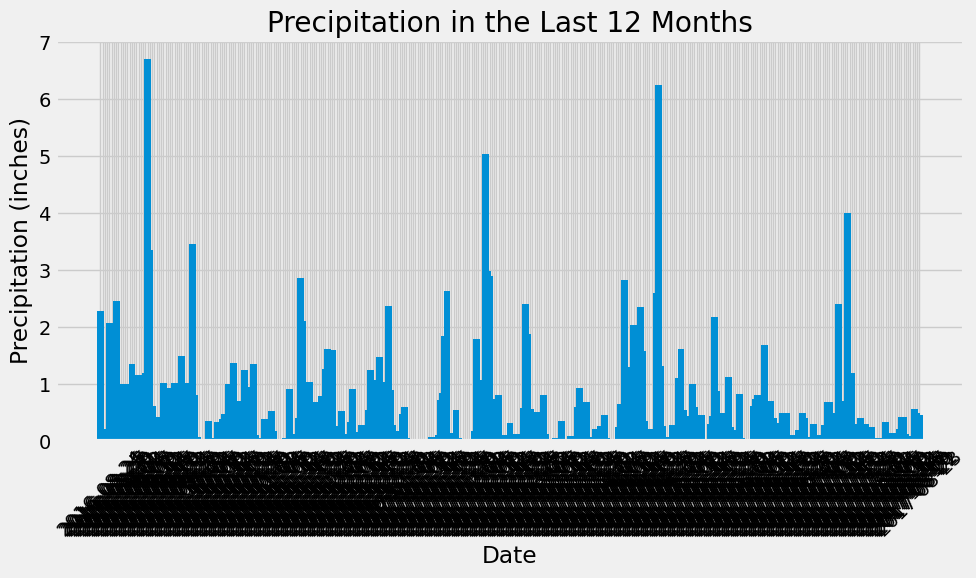

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

precipitation_data = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= one_year_ago).all()

df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

df = df.sort_values(by='Date')

plt.figure(figsize=(10,6))
plt.bar(df['Date'], df['Precipitation'], width=3)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"{total_stations}")


9


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Extract the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), 
func.max(Measurement.tobs), 
func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station_id).all()
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"For the most active station {most_active_station_id}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


For the most active station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


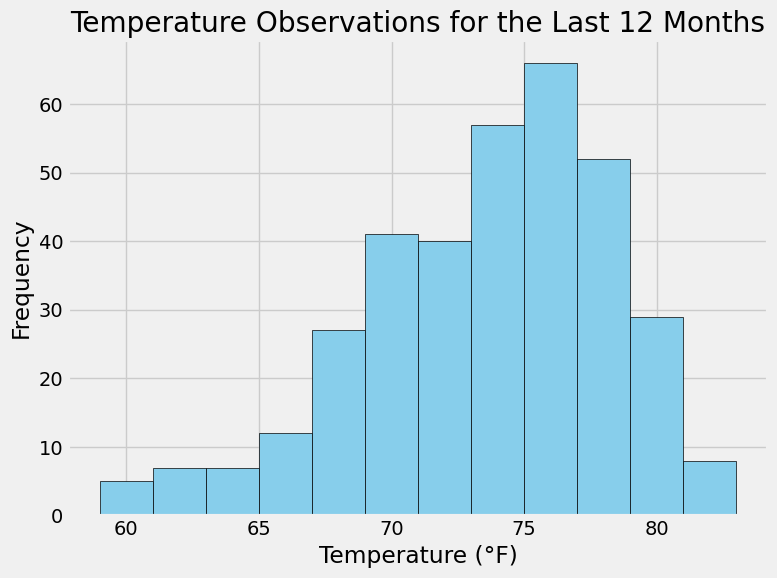

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
temperature_data = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station_id).\
filter(Measurement.date >= one_year_ago).all()
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])


plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [25]:
# Close Session
session.close()